6.1) The dynamics of a cart-pole system is given by the following equations:

<img src="eqn.png"
     alt="equation"
     style=" width:400px ; height 300px" />

The parameters are l = 0.8 (half length of pole), $m_{c}$ = 6 (mass of cart), $m_{p}$ = 3 (mass of pole), g = 9.81m/s2 (gravity), and −100N ≤ F ≤ +100N (force applied to the cart).The control interval shall be 0.01s. A zero-mean Gaussian noise vector ξ with diagonal covariance matrix Σ=diag(0.004, 0.04, 0.001, 0.01) shall be added after each control interval to the state vector (position, speed, angle, angular speed.
 
 
Implement a discrete-time simulator for this system.
Visualize, how the state evolves over 1s for the initial conditions
(position = -1m, velocity = 0.25m/s, angle = 0.3rad, angular velocity = -0.7 rad/s)
when no force is applied (F=0). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math

In [2]:
def get_acceleration(force,mp,l,ang_acc,theta,mc,angular_velocity):
    pos = (force -(mp*l*(ang_acc*math.cos(theta) - pow(angular_velocity,2)*math.sin(theta))))/(mc+mp)
    return pos

def get_angular_acceleration(force,mp,l,angular_velocity,theta,mc,g):
    num=(g*math.sin(theta)*(mc+mp))-((force+mp*l*pow(angular_velocity,2)*math.sin(theta))*math.cos(theta))
    den = ((4/3)*l*(mc+mp))-(mp*l*pow(math.cos(theta),2))
    ang_acc = num/den
    return ang_acc

In [3]:
# for noise
covariance_matrix = np.array([0.004,0.04,0.001,0.01])
time_step = 0.01


6.2) Find a linear (saturated) state-feedback policy

F = min(100, max(–100, k1\*position + k2\*velocity + k3\*angle + k4\*angular_velocity))

that moves the cart from the initial state to the target state region, described by the angle within
[−0.05rad, +0.05rad] and the position of the cart within [−0.1m, +0.1m].
The system fails, if the absolute pole angle is larger than 1.0 rad or the absolute cart position is
larger than 5 m. In case of a failure, the episode is stopped.
The final reward is computed by −(N − t), where N=1000 gives the maximum episode length and
t is the time step, where the failure occurred. This means, that a later failure is better than an
earlier failure. In case of the state being within the target region, the reward is 0 and the episode
is continued (since the system might leave the target region again). In every other situation, the
reward is −1.

Visualize the state trajectory of your policy and compute the return

In [4]:
def getForce(state,weight_vector):
    return min(100,max(-100,np.matmul(state,weight_vector)))

In [5]:
# %matplotlib inline

def applyForce(state,force,time,N = 1000):
    
    reward = 0
    
    if time >= N:
        return True, state, -(N - time)
    
    newstate = np.empty_like(state)
    
    ang_acc = get_angular_acceleration(force,3,0.8,state[3],state[2],6,9.81)
    acc = get_acceleration(force,3,0.8,ang_acc,state[2],6,state[3])

    # updating velocity
    newstate[1] = state[1] + acc*time_step

    # updating position
    newstate[0] = state[0] + newstate[1]*time_step

    # updating angular velocity
    newstate[3] = state[3] + ang_acc*time_step

    #updating angle
    newstate[2] = state[2] + newstate[3]*time_step
    
    # adding noise
    noise = [ np.random.normal(0, math.sqrt(variance), 1)[0]  for variance in covariance_matrix]

    newstate = newstate + noise
    
    if newstate[2] > 1 or newstate[0] > 5 or newstate[0] < -5 or newstate[2] < -1:
        return True,newstate,-(N-time)
        
    elif (newstate[2] <=0.05 and newstate[2] >= -0.05) and (newstate[0] <=0.1 and newstate[0] >=-0.1):
        reward = 0
    else:
        reward = -1
    
    return False,newstate,reward

In [6]:
def getLogParam(a,b):
    a = int(np.log10(a))
    b = int(np.log10(b))
    
    val = (b - a)*np.random.random() + a

    return np.power(10,val)

Current Parameters Learning rate 1 -  0.001, Learning rate 2 - 0.007 and gamma - 1.00 


/home/aakash/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:40: RuntimeWarning: overflow encountered in matmul
/home/aakash/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in subtract


Best time  126
Best Vector  [[ 4.37449423]
 [-3.63640961]
 [-2.95323132]
 [-4.57421186]]


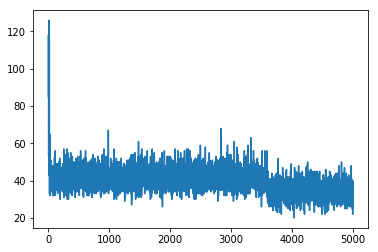

Current Parameters Learning rate 1 -  0.613, Learning rate 2 - 0.000 and gamma - 1.00 
Best time  94
Best Vector  [[ 515025.95141298]
 [1382765.23555482]
 [ 543406.4090145 ]
 [-216896.60055892]]


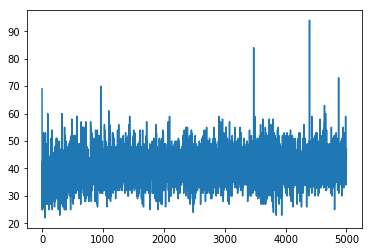

Current Parameters Learning rate 1 -  0.003, Learning rate 2 - 0.359 and gamma - 0.42 


/home/aakash/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:40: RuntimeWarning: overflow encountered in multiply


Best time  387
Best Vector  [[-2.04645291e+106]
 [ 4.83562829e+105]
 [ 6.82971660e+105]
 [-6.83341748e+105]]


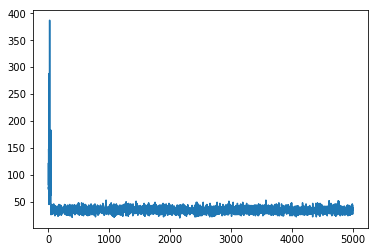

Current Parameters Learning rate 1 -  0.351, Learning rate 2 - 0.000 and gamma - 0.98 
Best time  84
Best Vector  [[ 1194.08549761]
 [-1280.02598754]
 [ -328.64785428]
 [ -577.83225356]]


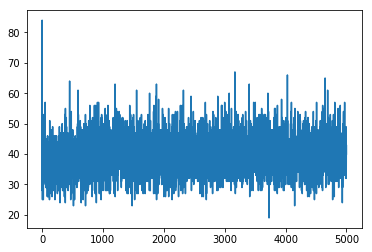

Current Parameters Learning rate 1 -  0.000, Learning rate 2 - 0.419 and gamma - 0.96 
Best time  267
Best Vector  [[ 0.06938586]
 [ 0.38839961]
 [-1.35884643]
 [ 0.14505996]]


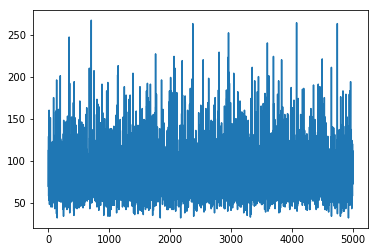

In [7]:
# 5000 episodes for a single parameter, decrease the value to run the code quickly
EPISODES = 5000


# trying five random hyper parameters
for i in range(5):

    times = []
    
    # parameters learning rates and gamma
    learning_rate = getLogParam(0.0001,1)
    lr2 = getLogParam(0.0001,1)
    gamma = 1 - getLogParam(0.0001,1)
    
    print("Current Parameters Learning rate 1 -  %.3f, Learning rate 2 - %.3f and gamma - %.2f " % (learning_rate,lr2,gamma) )
    
    # storing rewards for every set of parameters
    rewards = []

    # initialising weight vector and q vector
    weight_vector = np.random.rand(4,1)*2 - 1
    q_vector = np.random.rand(4,1)

    best_time = -1
    bestweight = weight_vector
    
    for episode in range(1,EPISODES+1):

        #intial state with position, velocity, angle and angular velocity
        state = np.array([-1,0.25,0.3,-0.7])
        time = 0
        endOfEpisode = False
        
        while not endOfEpisode:
            # calculating and applying force
            force = getForce(state,weight_vector)
            endOfEpisode,newState,reward = applyForce(state,force,time)
            
            # calculating gradient
            error = (reward + gamma*np.matmul(newState,q_vector) - np.matmul(state,q_vector))*state.reshape(4,1)
            
            # learning of weights for calculating force and q values
            weight_vector = weight_vector + (learning_rate)*error
            q_vector += lr2*error
            
            #saving reward for visualisation
            rewards.append(reward)
            
            #updating state and time step
            state = newState
            time = time + 1
        
        # saving the best weights
        if best_time < time:
            best_time = time
            bestweight = weight_vector
        
        # saving time steps before failure 
        times.append(time)
        
    # print and visualising the results from ith parameters
    print("Best time ", best_time)
    print("Best Vector ",bestweight )
    sns.lineplot(data = np.array(times))

    plt.show()
            

Current Parameters Learning rate 1 -  0.442, Learning rate 2 - 0.002 and gamma - 0.98 
Best time  1001
Best Vector  [[  7569.54243175]
 [ 17693.0021908 ]
 [143274.70172674]
 [ 74417.22530822]]


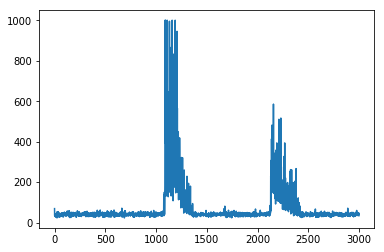

In [8]:
# one of the hyper parameters we learned and saved
learning_rate = 0.4419813188036535
lr2 = 0.0023529448361502203
gamma = 0.9831519207326977


times = []
EPISODES = 3000
print("Pre Learned hyper-parameters Learning rate 1 -  %.3f, Learning rate 2 - %.3f and gamma - %.2f " % (learning_rate,lr2,gamma) )

# storing rewards for every set of parameters
rewards = []

# initialising weight vector and q vector
weight_vector = np.random.rand(4,1)*2 - 1
q_vector = np.random.rand(4,1)

best_time = -1
bestweight = weight_vector

for episode in range(1,EPISODES+1):

    #intial state with position, velocity, angle and angular velocity
    state = np.array([-1,0.25,0.3,-0.7])
    time = 0
    endOfEpisode = False

    while not endOfEpisode:
        # calculating and applying force
        force = getForce(state,weight_vector)
        endOfEpisode,newState,reward = applyForce(state,force,time)

        # calculating gradient
        error = (reward + gamma*np.matmul(newState,q_vector) - np.matmul(state,q_vector))*state.reshape(4,1)

        # learning of weights for calculating force and q values
        weight_vector = weight_vector + (learning_rate)*error
        q_vector += lr2*error

        #saving reward for visualisation
        rewards.append(reward)

        #updating state and time step
        state = newState
        time = time + 1

    # saving the best weights
    if best_time < time:
        best_time = time
        bestweight = weight_vector

    # saving time steps before failure 
    times.append(time)

# print and visualising the results from ith parameters
print("Best time ", best_time)
print("Best Vector ",bestweight )
sns.lineplot(data = np.array(times))

plt.show()


In [9]:

# one of the parameters we learned
bw = np.random.rand(4,1)
bw[0][0] = 543.40393412
bw[1][0] = 608.30404927
bw[2][0] = 6844.44966102
bw[3][0] = 2523.15630138


In [10]:
# %matplotlib inline

Total rewards:  -982


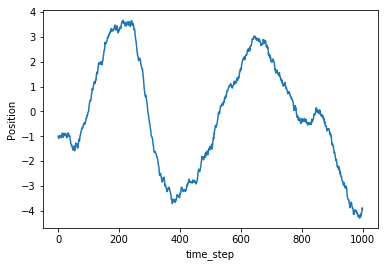

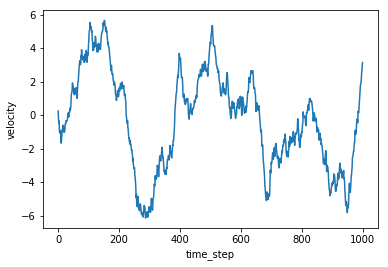

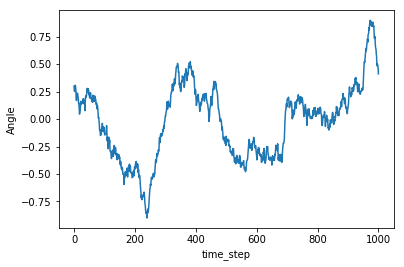

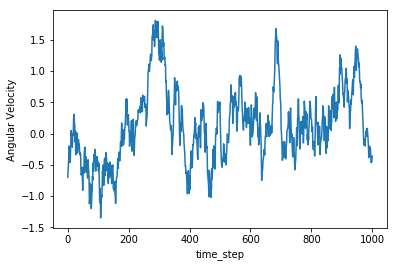

In [11]:
endOfEpisode = False

#intial state with position, velocity, angle and angular velocity
state = np.array([-1,0.25,0.3,-0.7])
time = 0
rewards = []

states =[]

while not endOfEpisode:
        states.append(state)
        force = getForce(state,bw)
        endOfEpisode,newState,reward = applyForce(state,force,time)
        rewards.append(reward)
        state = newState
        time = time + 1
        

    

states = np.array(states)

rewards = np.array(rewards)

print("Total rewards: ",rewards.sum())

sns.lineplot(data = states[:,0].flatten())
plt.xlabel('time_step')
plt.ylabel('Position')
plt.show()

sns.lineplot(data = states[:,1].flatten())
plt.xlabel('time_step')
plt.ylabel('velocity')
plt.show()

sns.lineplot(data = states[:,2].flatten())
plt.xlabel('time_step')
plt.ylabel('Angle')
plt.show()

sns.lineplot(data = states[:,3].flatten())
plt.xlabel('time_step')
plt.ylabel('Angular Velocity')
plt.show()